In [27]:
import matplotlib.pyplot as plt
import numpy as np
import miepython
import copy
from scipy.spatial import cKDTree
import pandas as pd
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from PIL import Image, ImageFilter
from matplotlib import colormaps
import torch.optim as optim
import torch.nn as nn
from os import listdir
from os.path import isfile, join
import re
import random
import imageio.v2 as iio
import csv
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import os

# Functions

In [24]:
def get_files(dir, key=".*\.png"):
    # For a directory "dir", return a list of all files which match the regex expression "key"
    all_files = [f for f in listdir(dir) if isfile(join(dir, f))]
    files=[]
    for file in all_files:
        match = re.search(key,file)
        if match != None:
            files.append(file)
    files.sort()
    return files

def get_image(image_path, size, trim):
    """Get a numpy array of an image so that one can access values[x][y]."""
    image = Image.open(image_path, "r")
    image = image.resize((size,size))
    pixel_values = list(image.getdata())
    if image.mode == "RGB":
        channels = 3
    elif image.mode == "L":
        channels = 1
    elif image.mode == "RGBA":
        channels = 4
    else:
        print("Unknown mode: %s" % image.mode)
        return None
    pixel_values = np.array(pixel_values).reshape((size, size, channels))
    sum_vales = (pixel_values[:,:,0]+pixel_values[:,:,1]+pixel_values[:,:,2])[trim:-trim,trim:-trim]
    return sum_vales[:,:]/sum_vales[:,:].max()

def get_scan(file, theta0, dtheta,vmin = 370):
    # Reads a lidar scan "file", returns the xz and rtheta coordinates of the points, as well as the optical depth for that file
    rows=[]
    with open(file, 'r') as fd:
        reader = csv.reader(fd)
        for row in reader:
            rows.append(row)
    data = rows[35][0].split(';')
    r = [float(string) for string in data]
    theta = np.linspace(-theta0,-theta0+len(r)*dtheta,len(r))
    x = r*np.sin(theta)
    z = r*np.cos(theta)
    xz = np.column_stack((x, z))
    rtheta = np.column_stack((r, theta))
    v_max = int(re.search(".*\/(...)_...\.ubh",file)[1]) # This regex line pulls out v_max 
    v = int(re.search(".*\/..._(...)\.ubh",file)[1]) # This regex line pulls out v
    return xz, rtheta, tau(v,v_min,v_max)

# Main

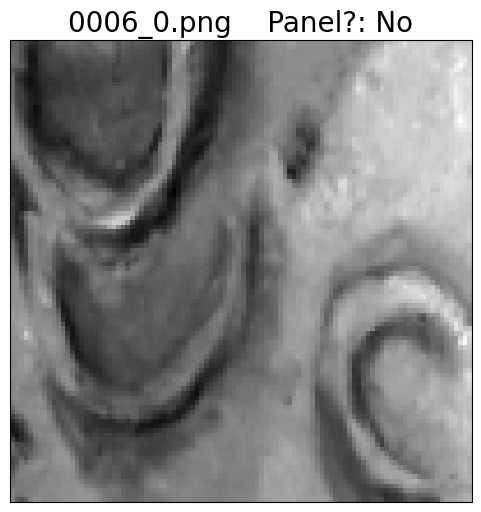

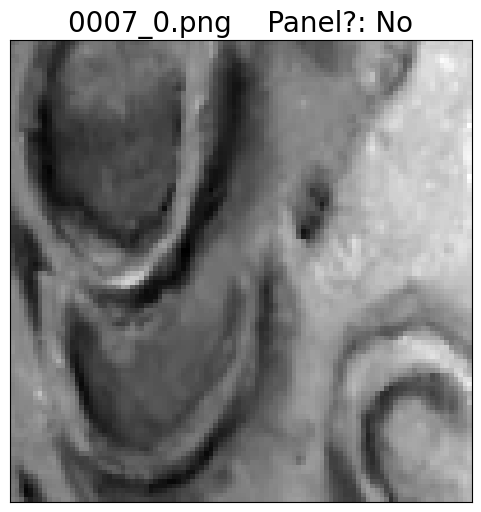

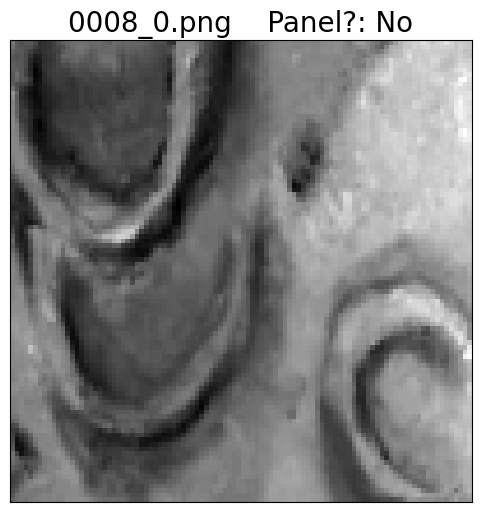

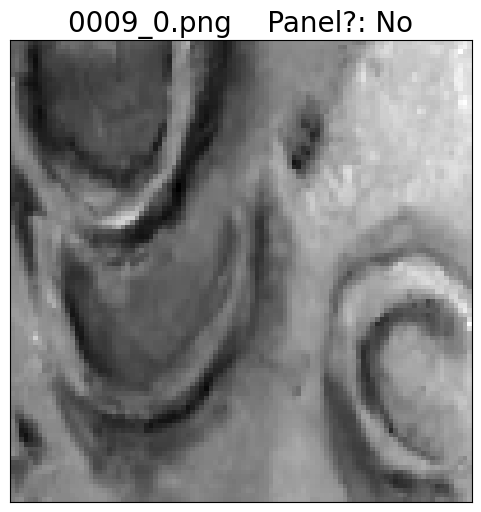

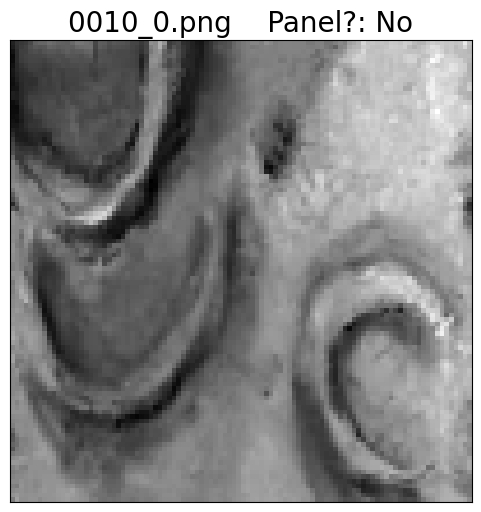

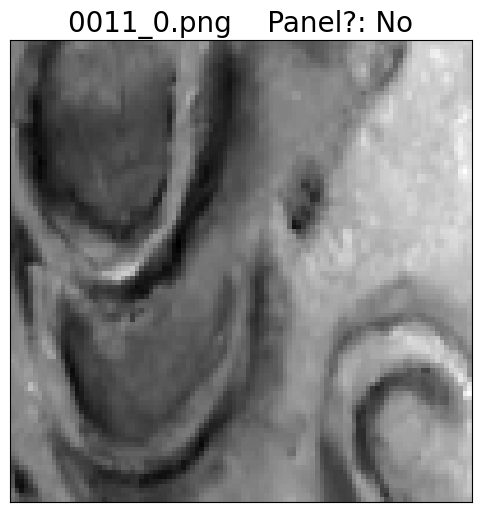

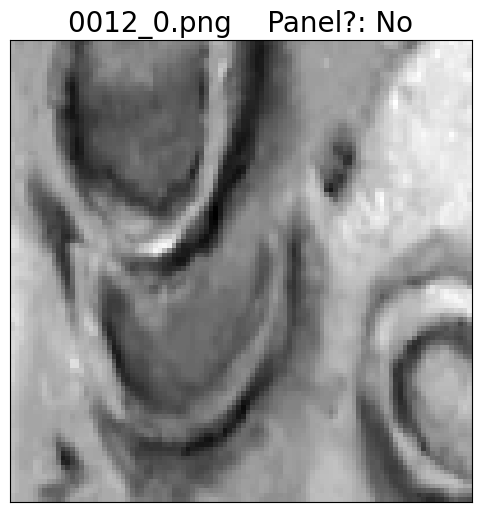

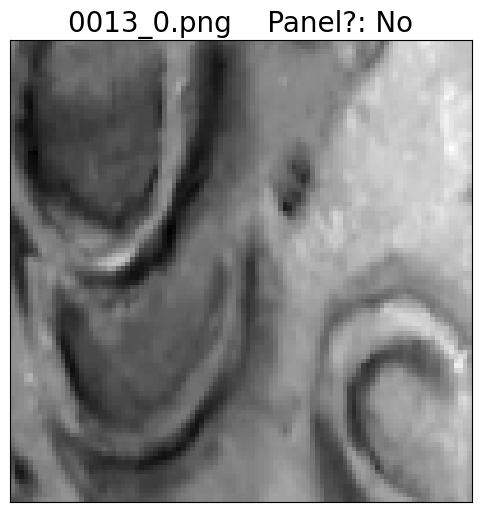

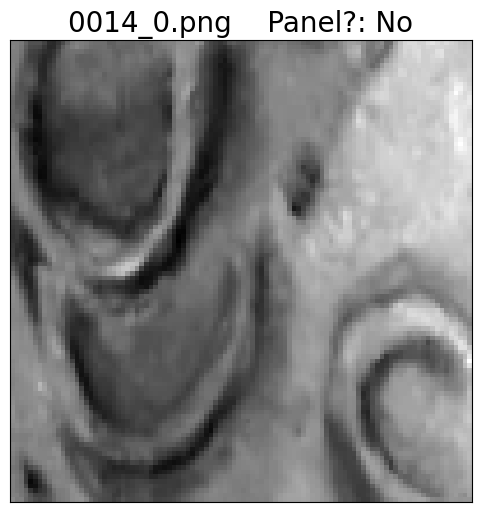

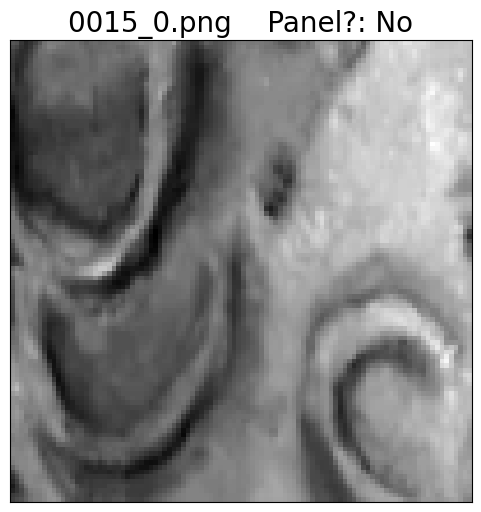

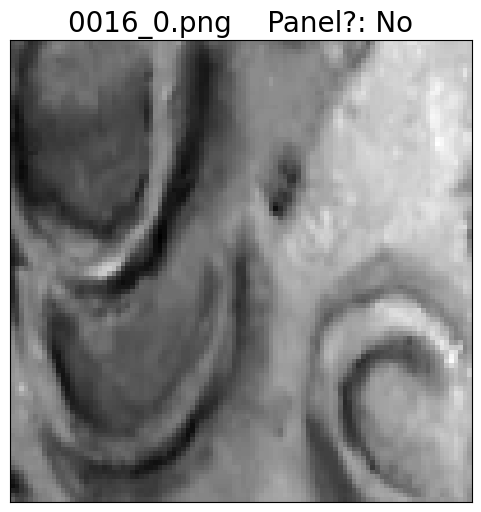

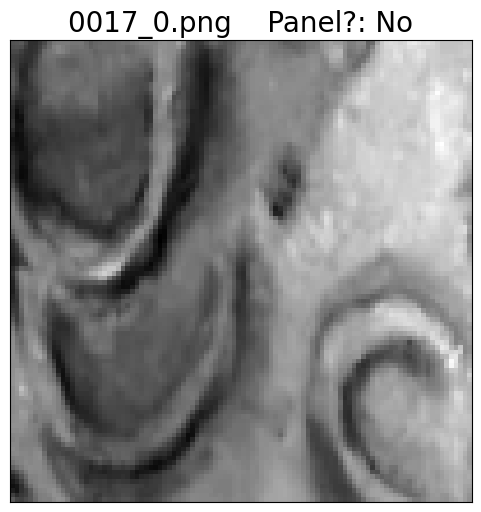

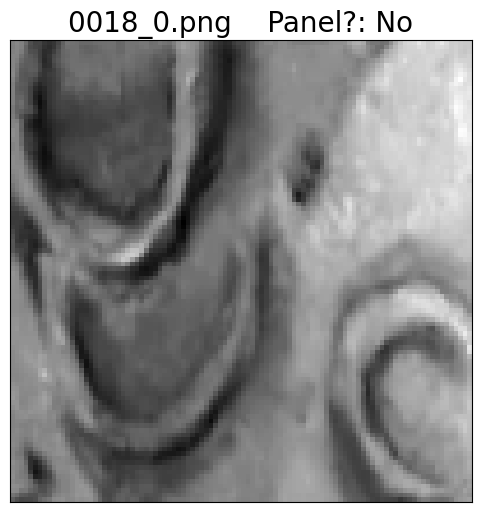

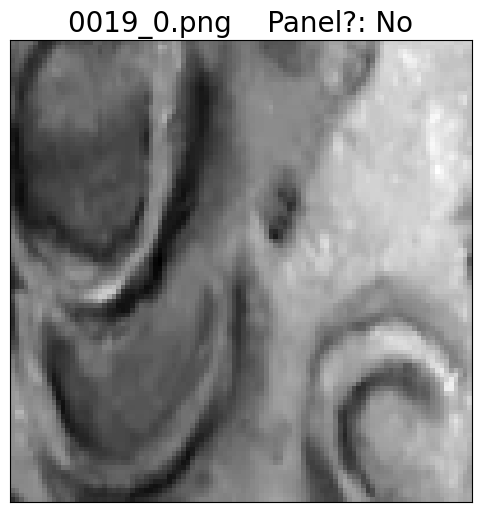

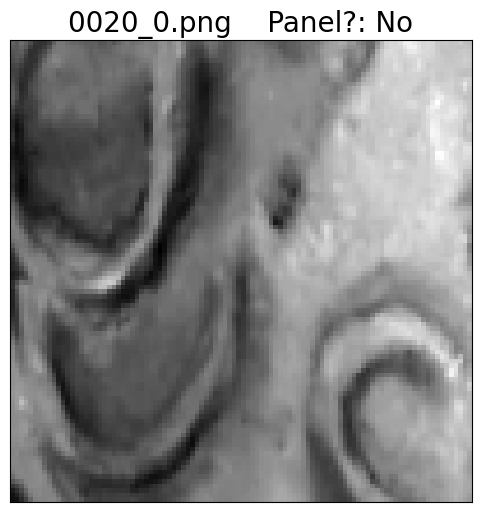

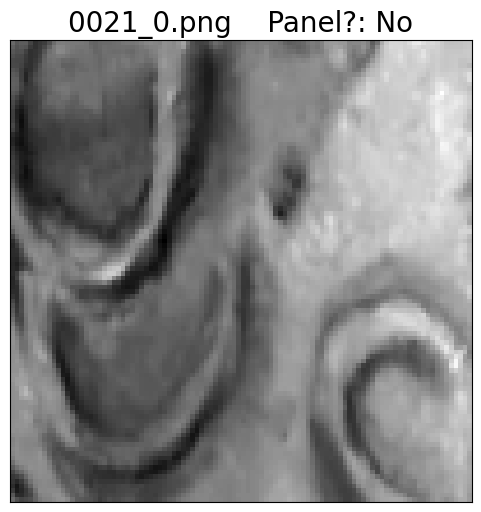

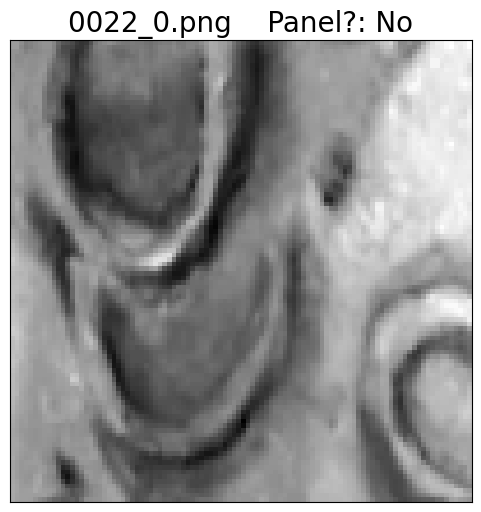

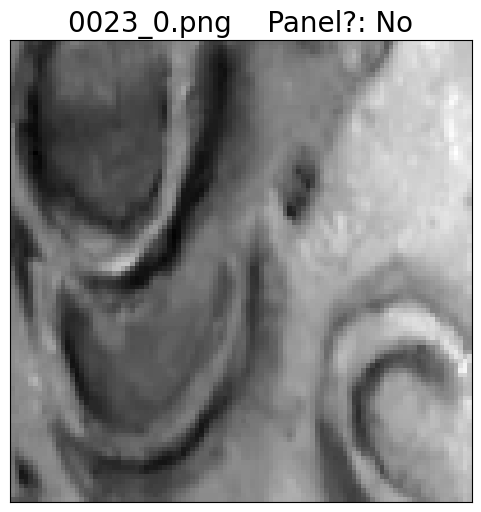

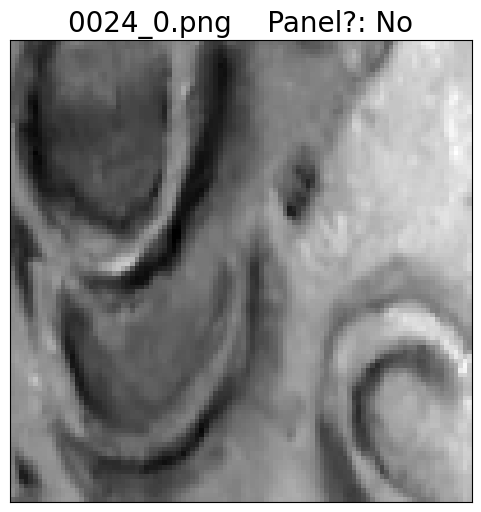

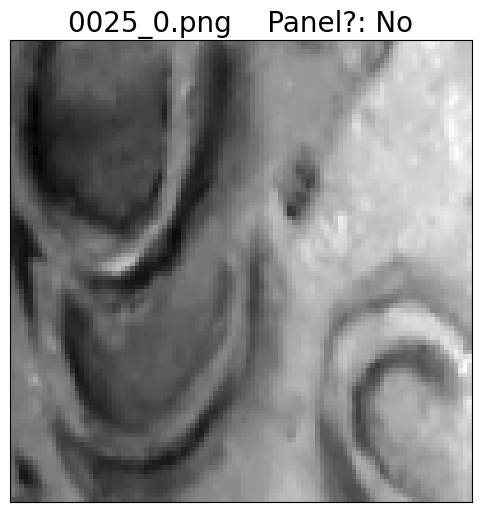

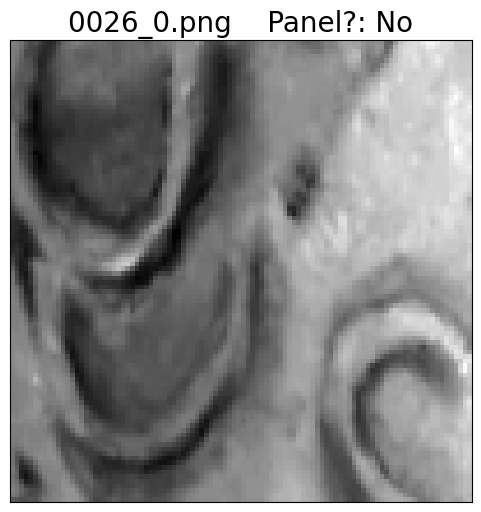

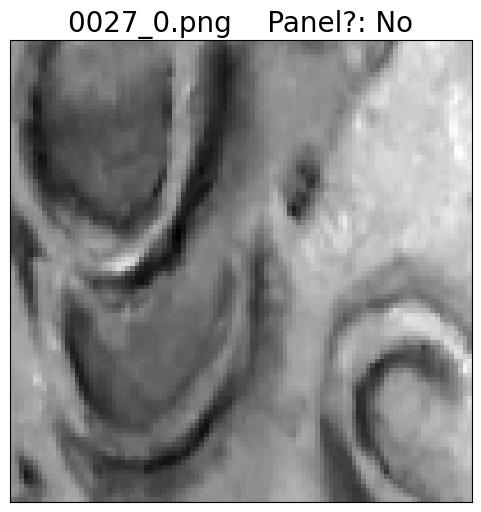

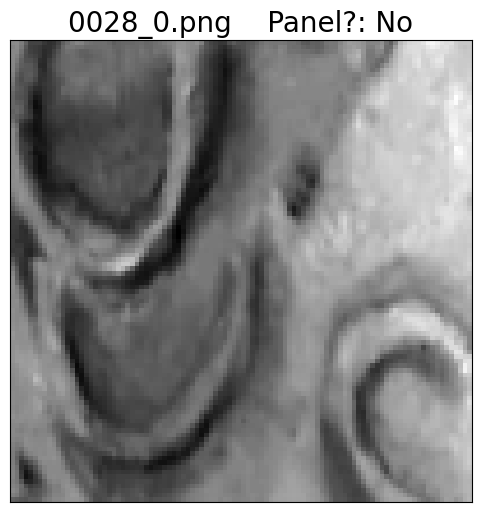

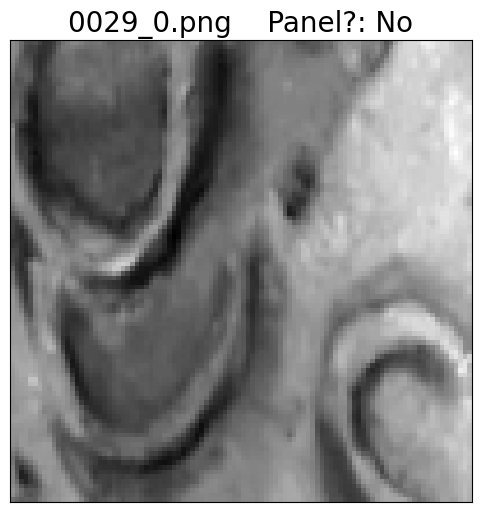

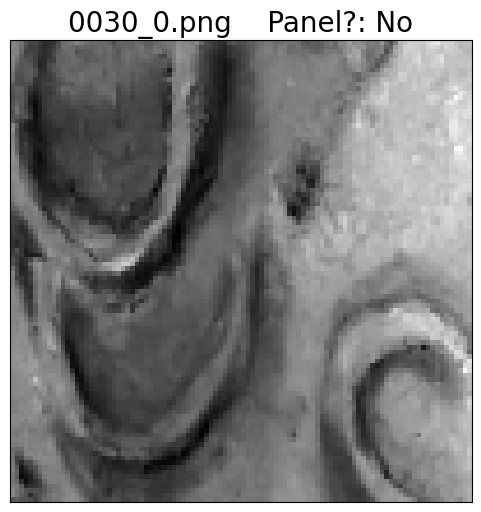

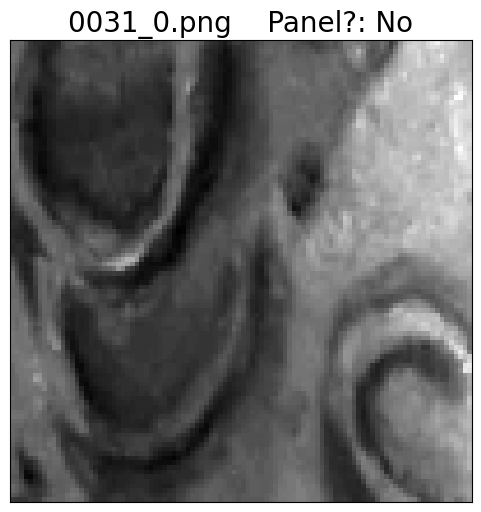

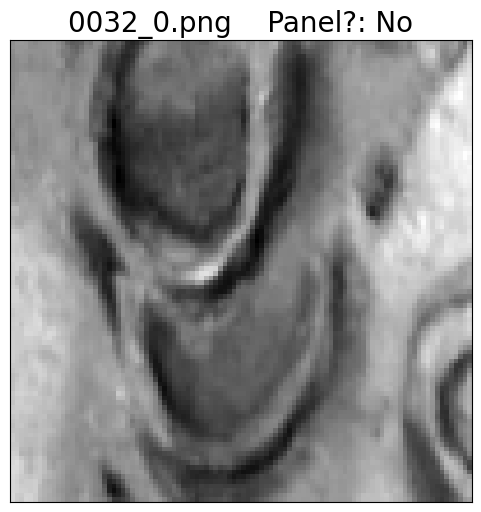

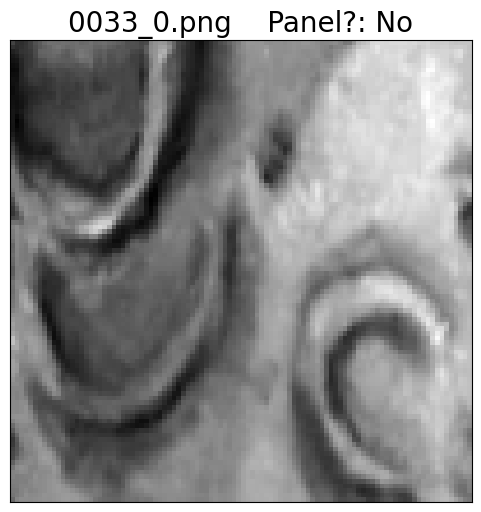

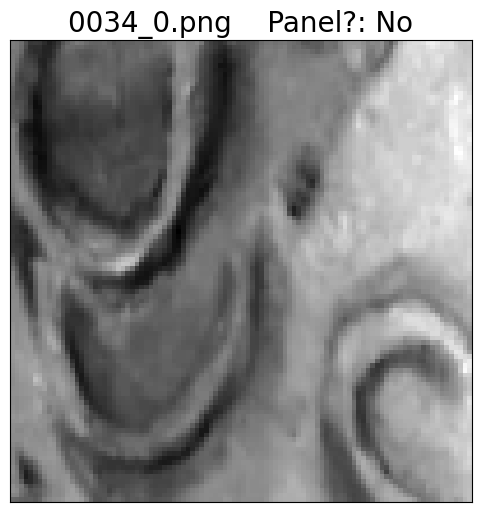

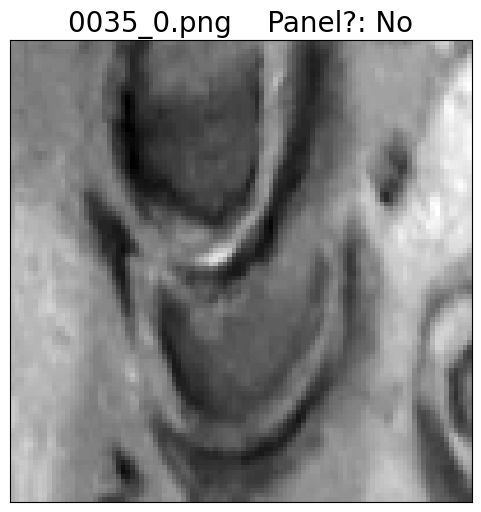

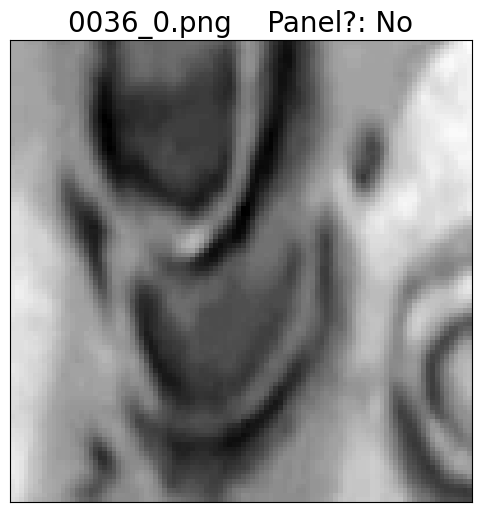

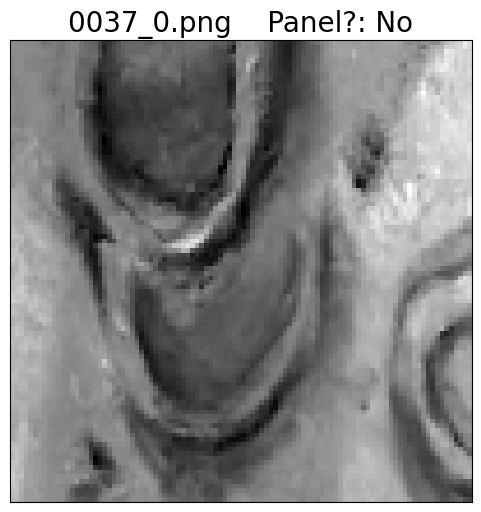

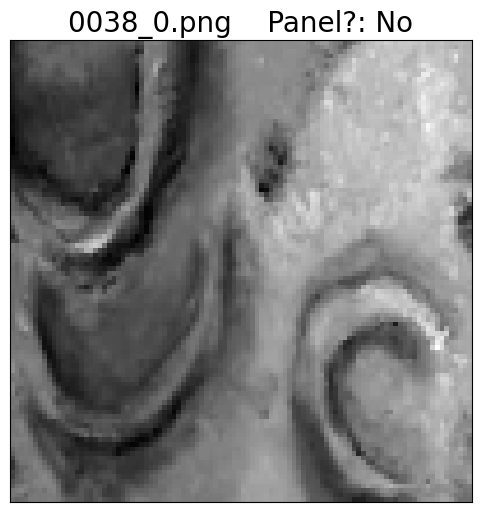

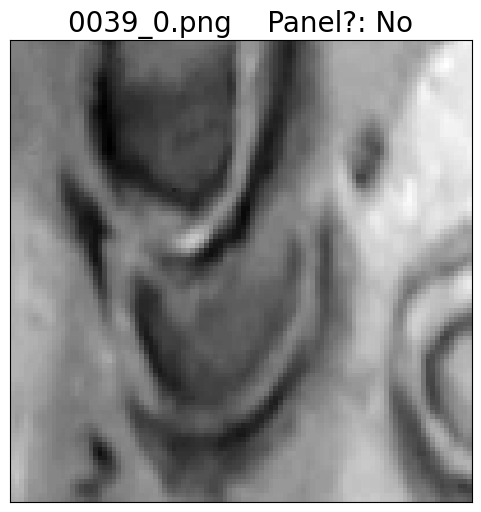

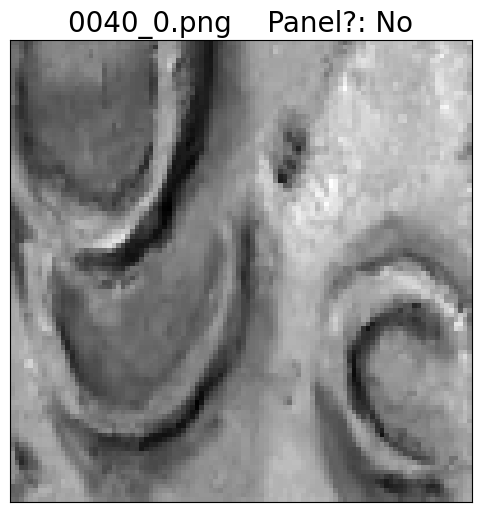

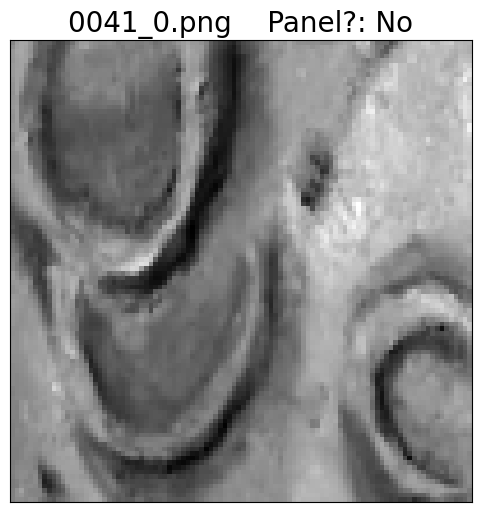

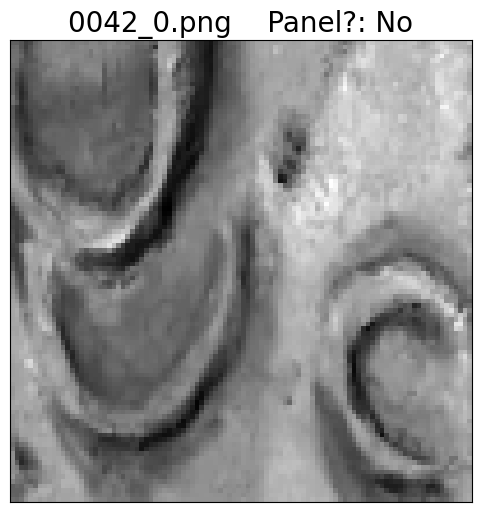

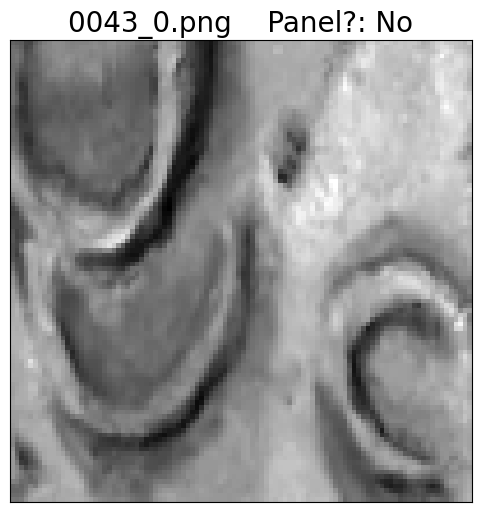

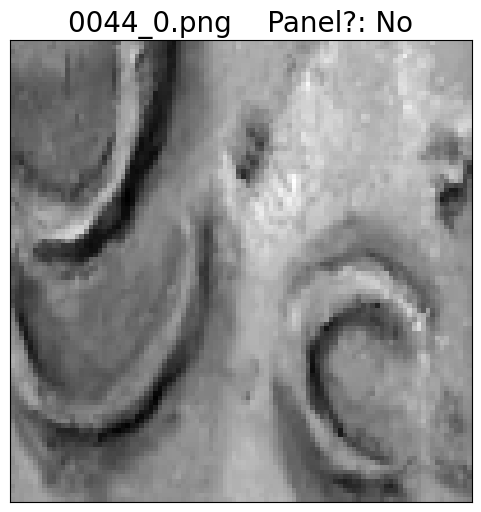

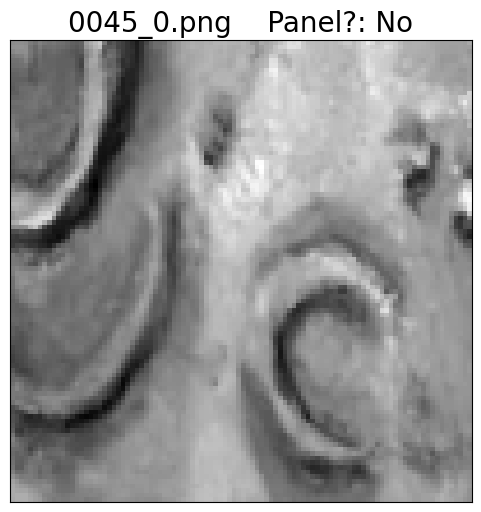

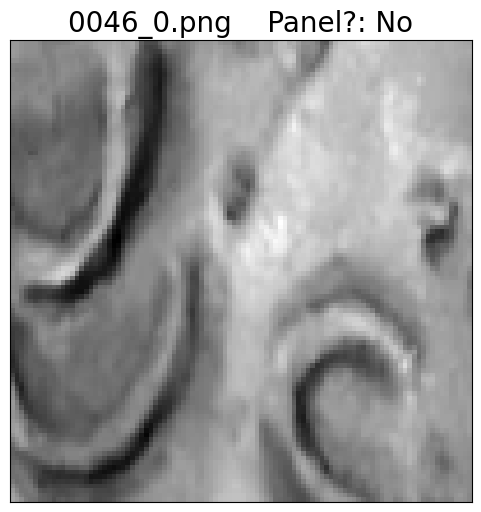

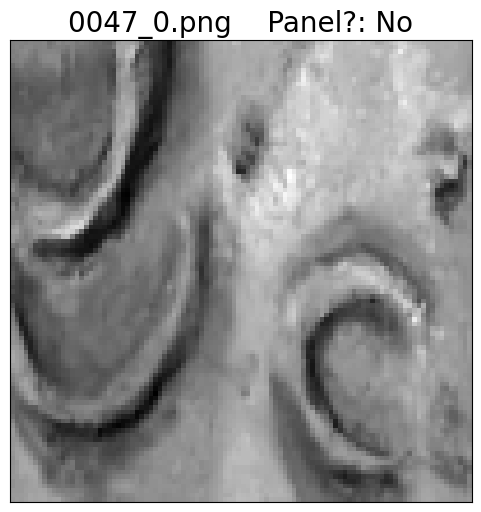

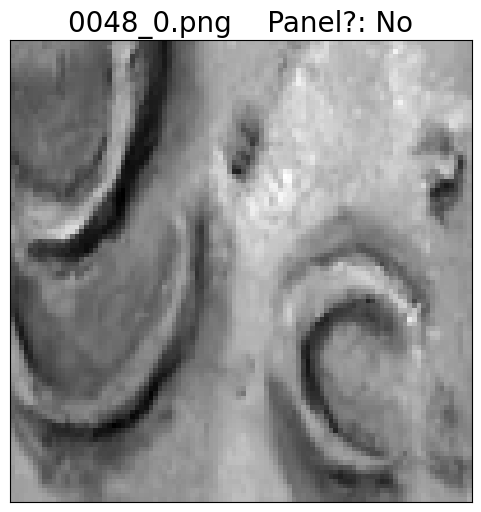

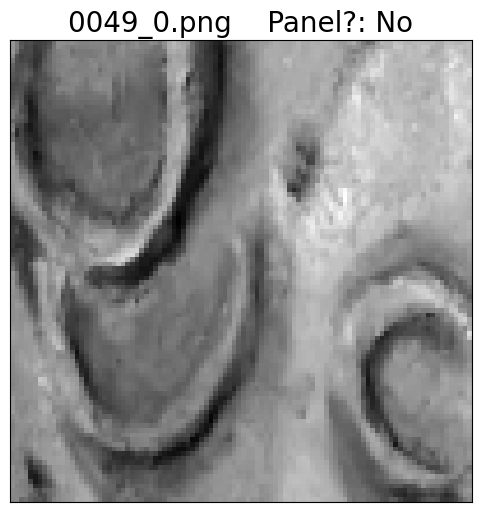

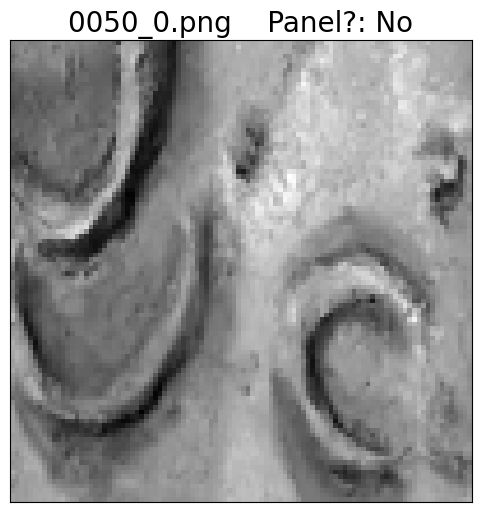

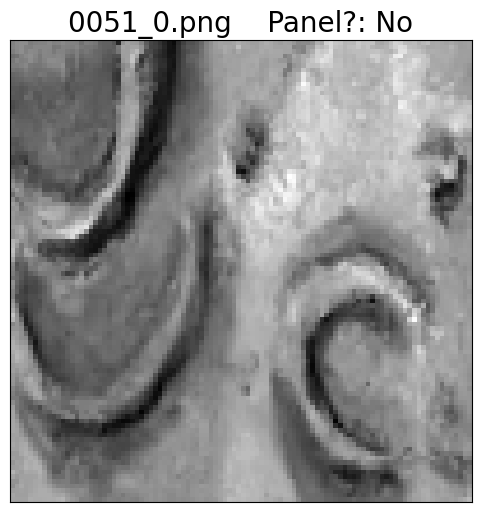

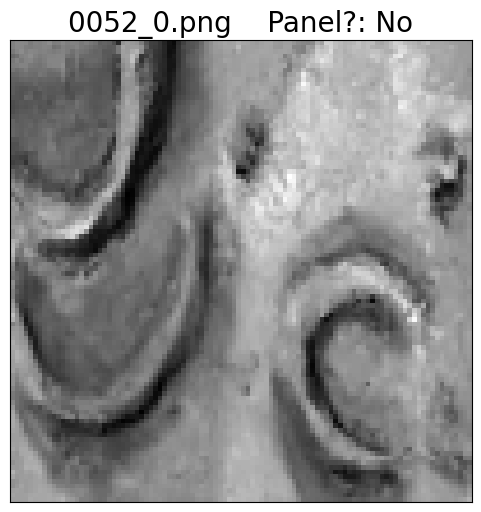

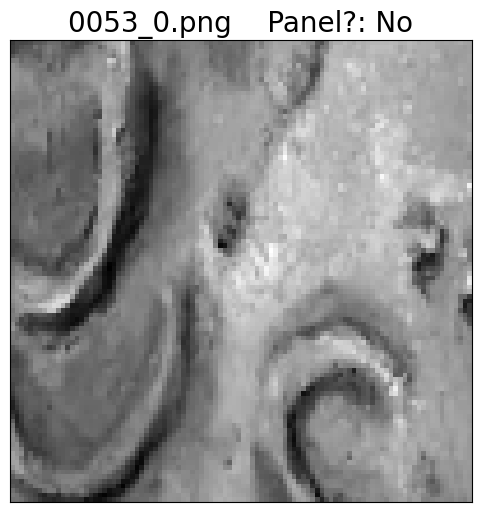

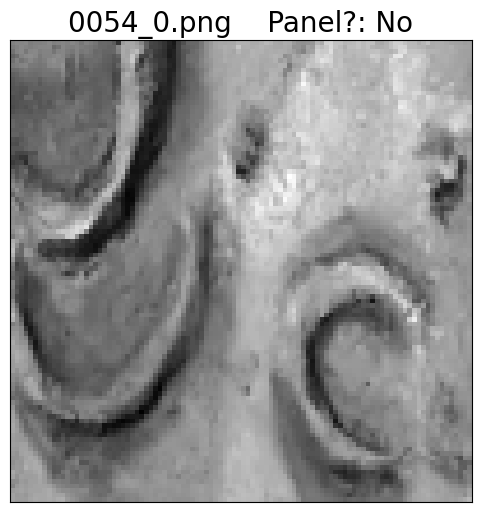

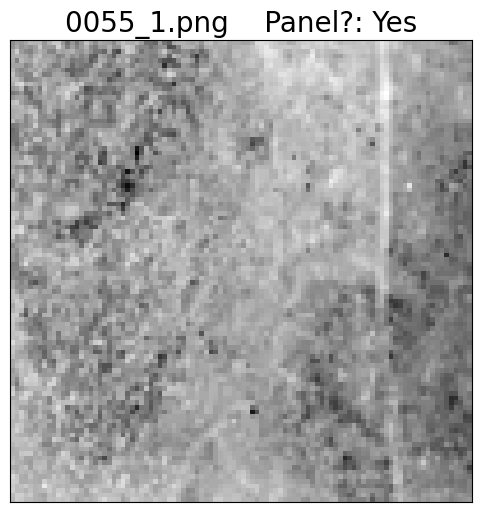

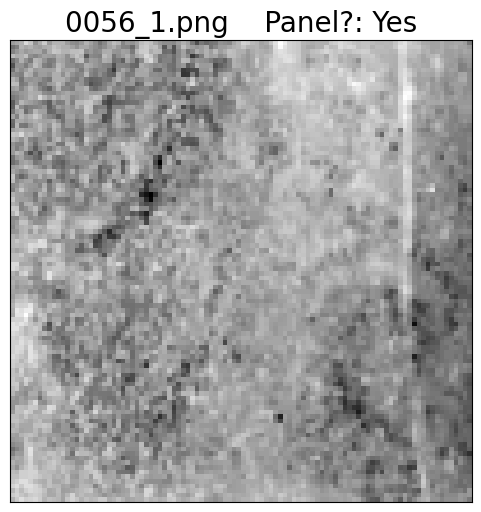

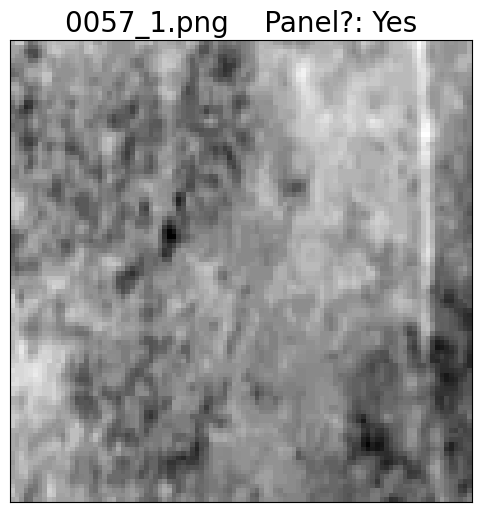

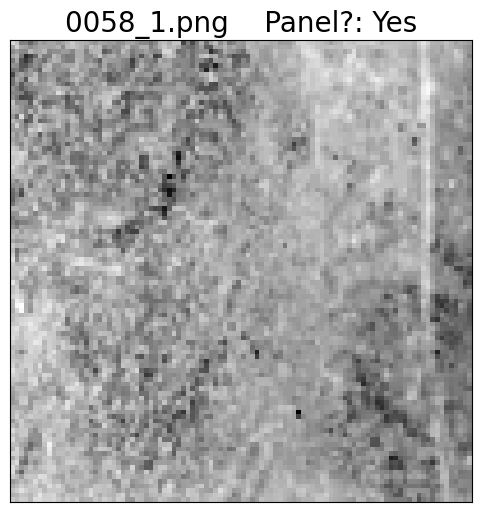

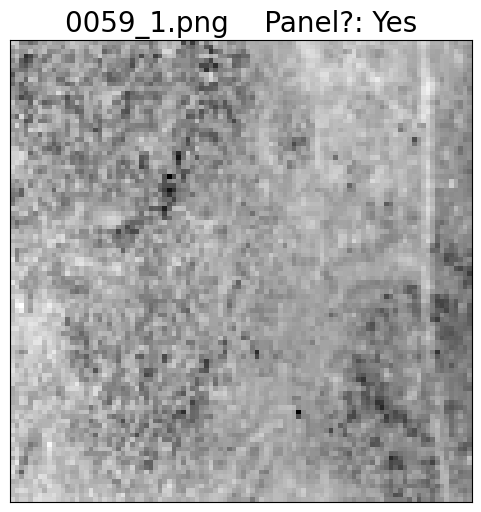

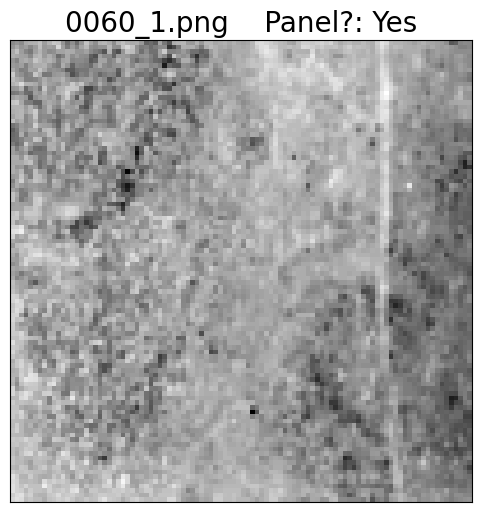

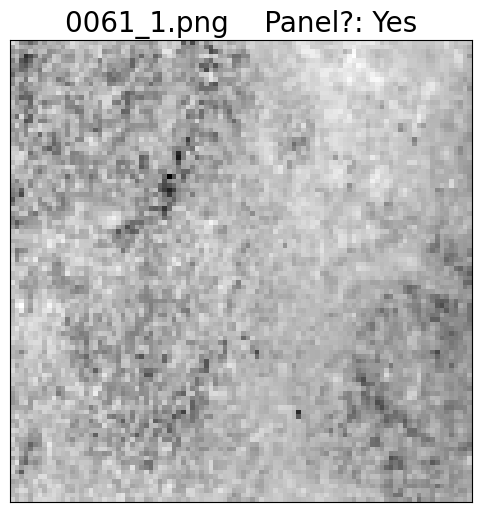

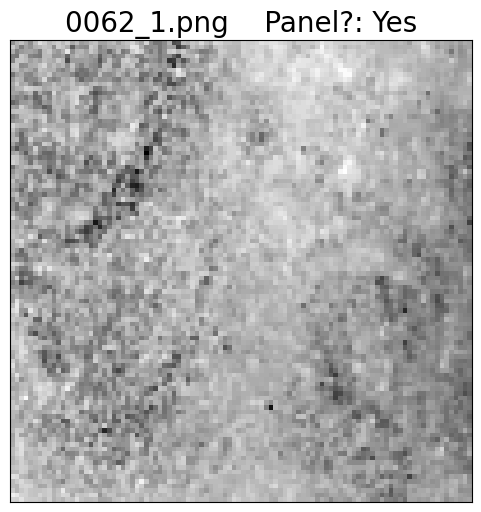

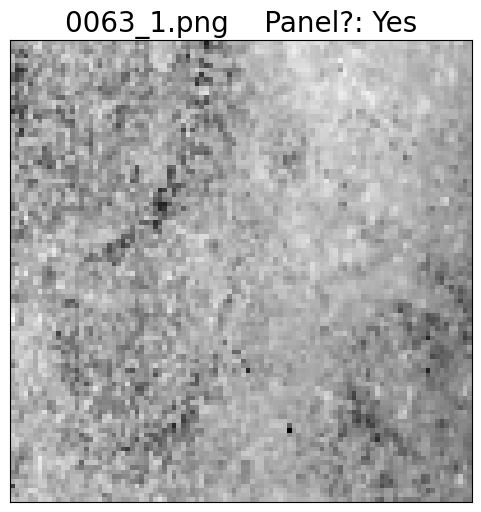

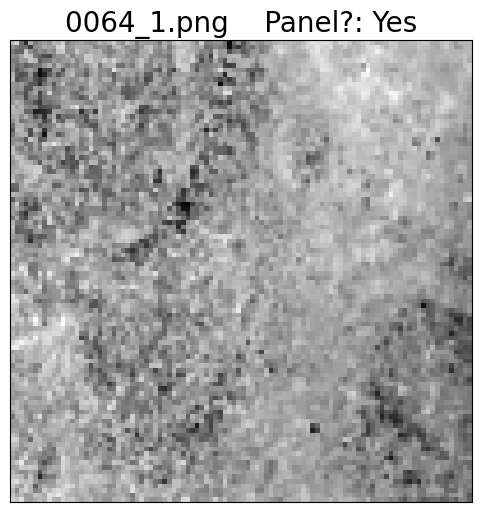

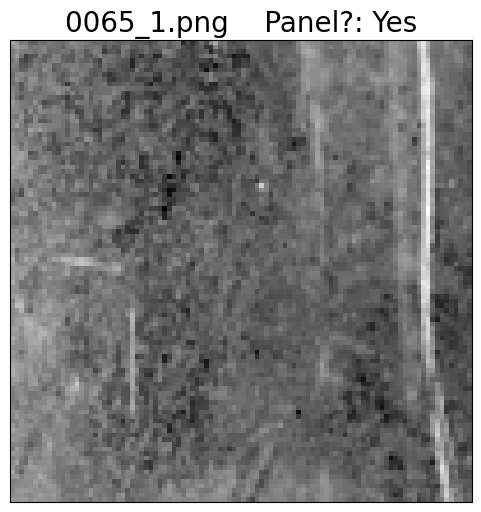

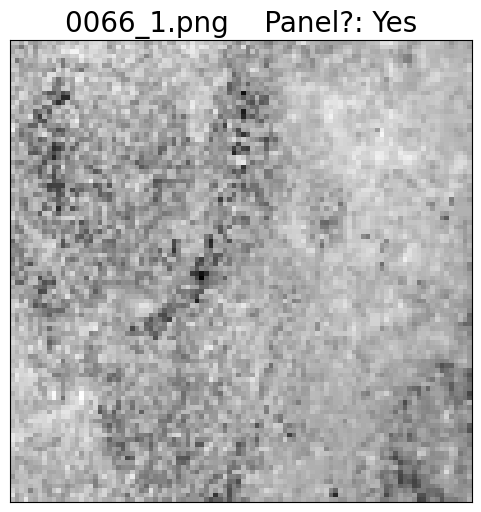

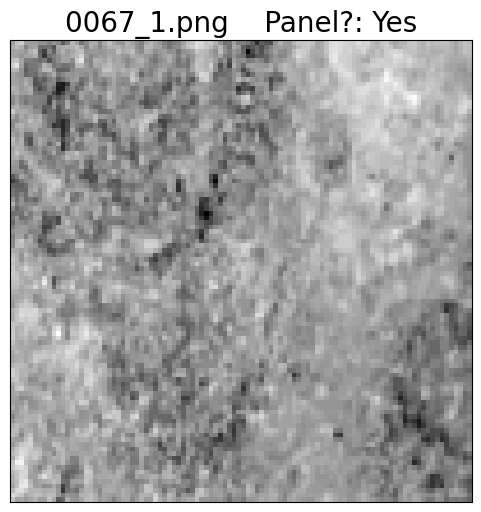

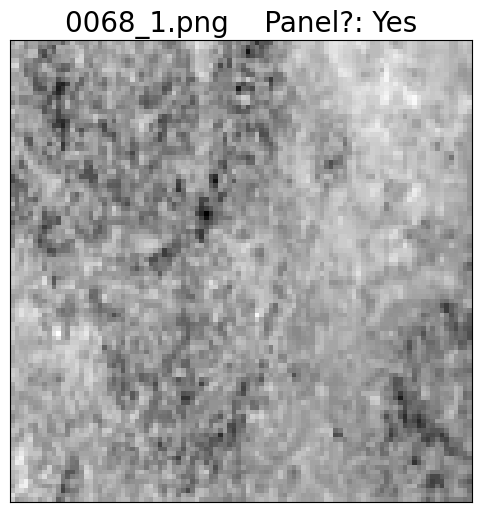

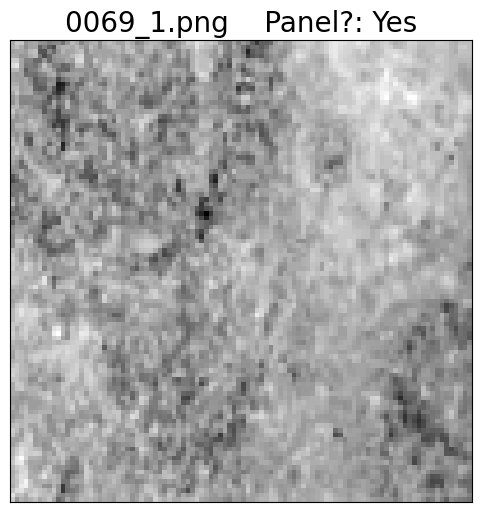

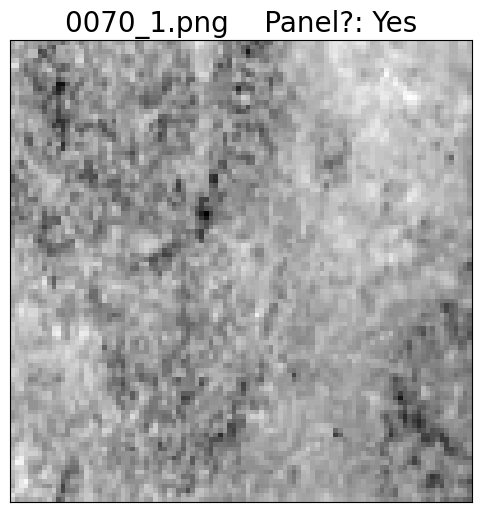

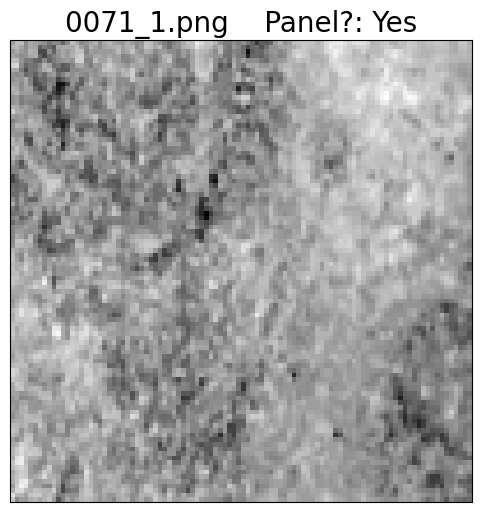

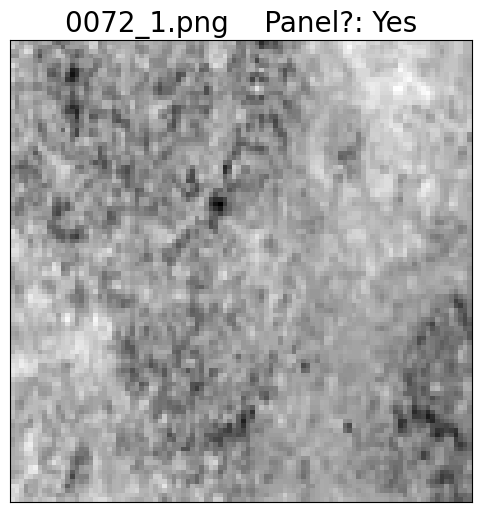

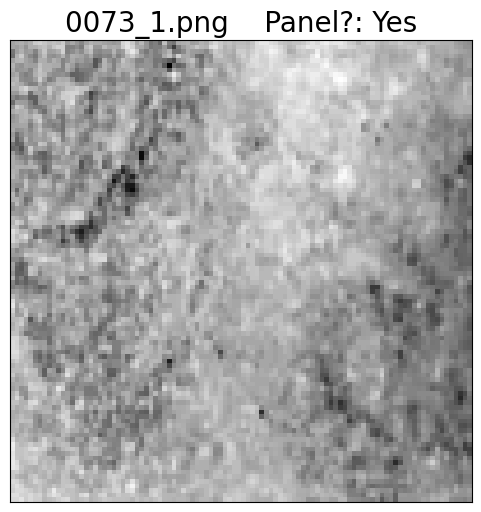

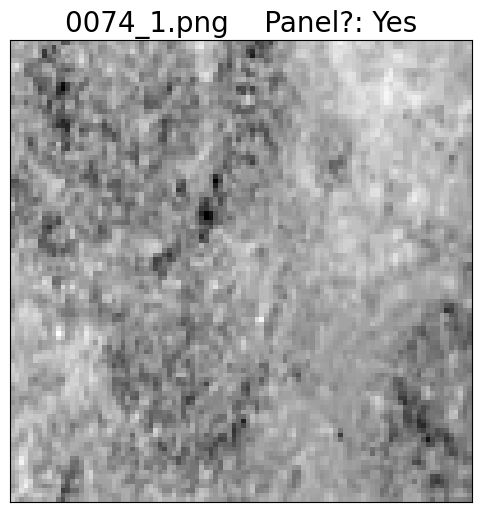

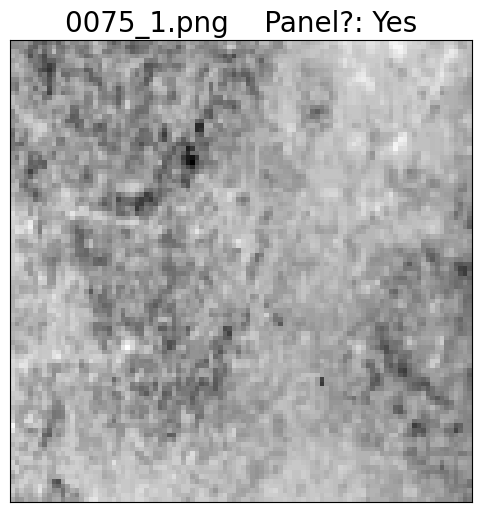

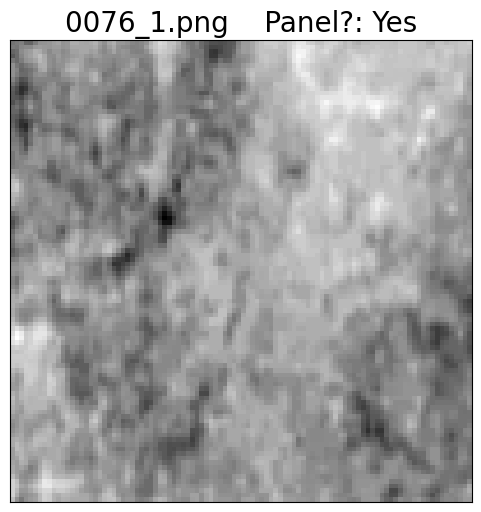

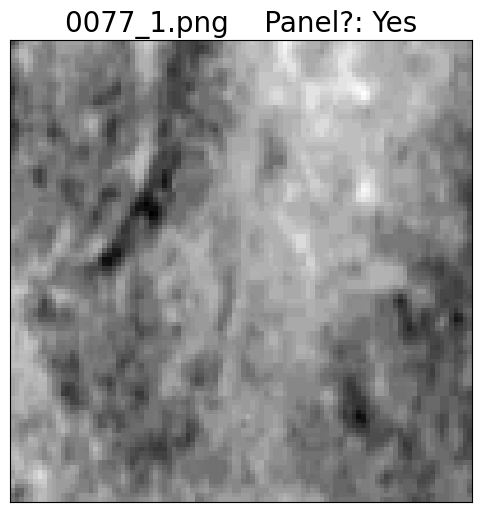

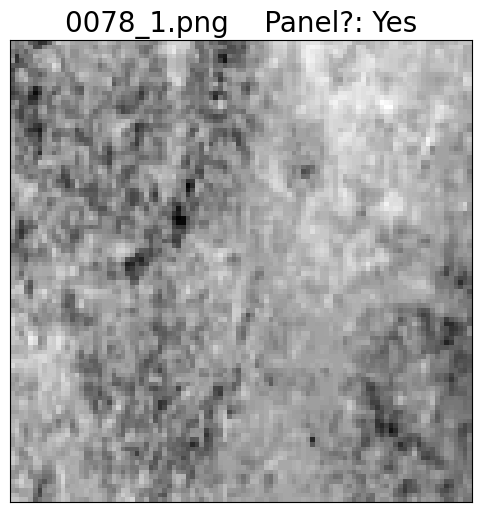

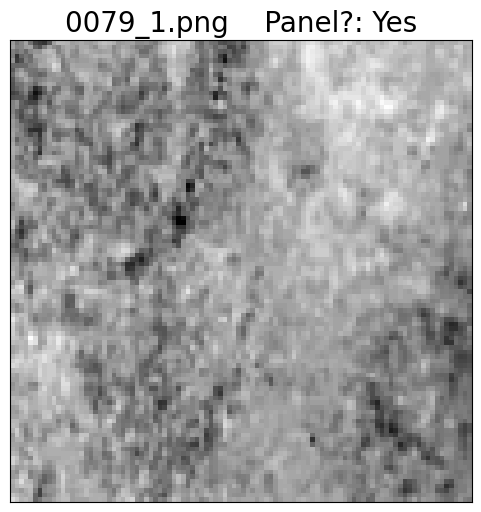

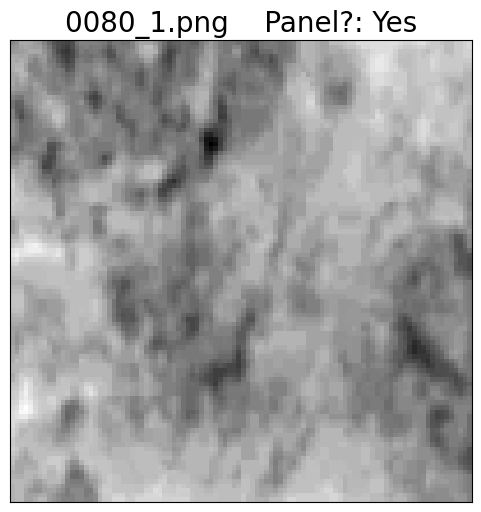

In [26]:
# Import images

dir = "prototype_photos/"
size = 300 # photo will be read in as size x size
trim = 100 # remove this many pixels from each edge

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

files = get_files(dir)
panel_ls = []
im_ls = []
for file in files:
    fig, ax = plt.subplots(figsize=(6,6))
    panel = int(re.search(".*_(.).png",file)[1]) # This regex line pulls if there is a panel or not
    im = get_image(str(dir+file),size,trim)
    ax.imshow(im,cmap="grey")
    if panel==0:
        title="No"
    else:
        title="Yes"
    ax.set_title(str(file+"    Panel?: "+title),fontsize = 20)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    panel_ls.append(panel)
    im_ls.append(im)

Text(0, 0.5, 'Number of samples')

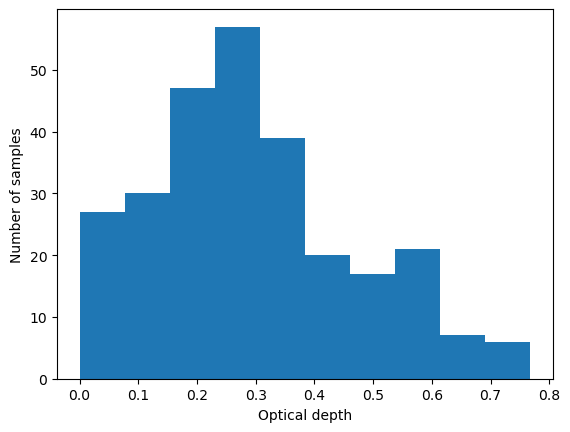

In [4]:
plt.hist(tau_ls)
plt.xlabel("Optical depth")
plt.ylabel("Number of samples")

Epoch: 0


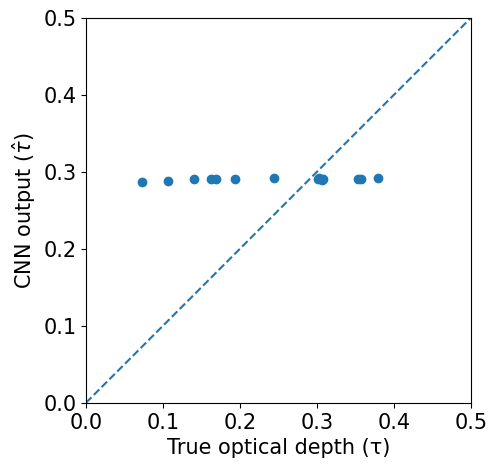

Epoch: 1200000


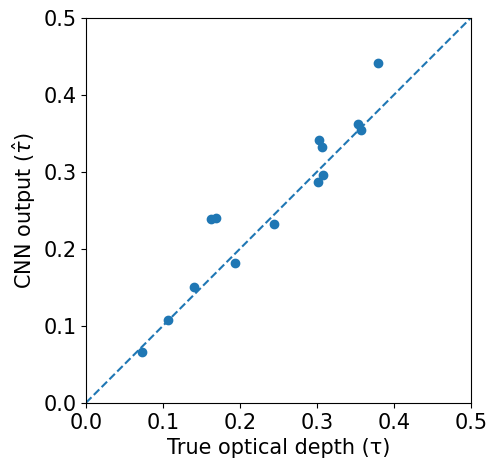

Epoch: 2400000


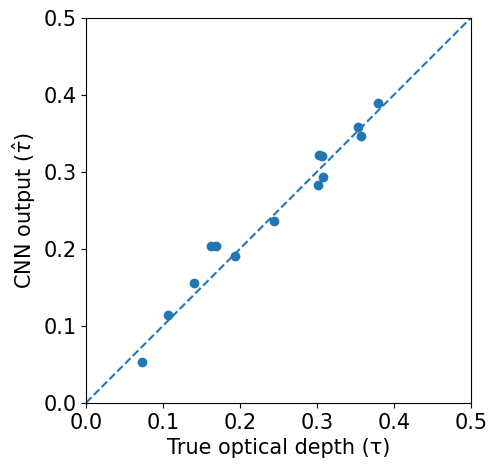

Epoch: 3600000


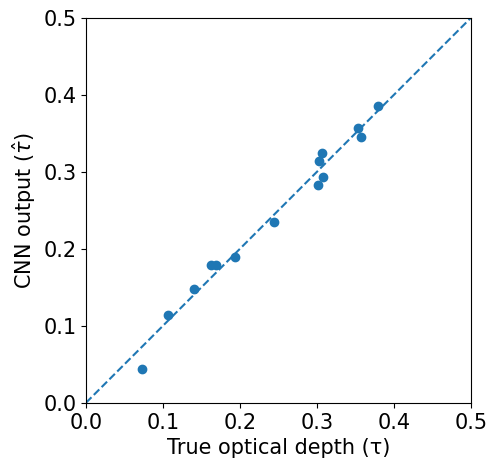

Epoch: 4800000


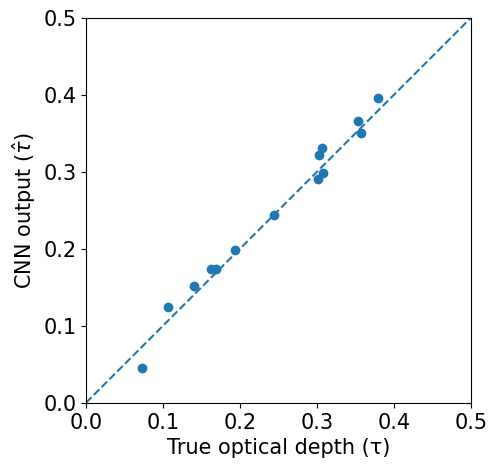

Complete!


OverflowError: Exceeded cell block limit in Agg.  Please set the value of rcParams['agg.path.chunksize'], (currently 0) to be greater than 100 or increase the path simplification threshold(rcParams['path.simplify_threshold'] = 0.111111111111 by default and path.simplify_threshold = 0.111111111111 on the input).

<Figure size 640x480 with 1 Axes>

In [5]:
# Train CNN
# Define hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
myseed = 44
lr = 2e-4
n_epochs = 6000000
plot_every = n_epochs/5
test_size = 20

# Convert training data to tensors
im_tensor = torch.tensor(np.reshape(im_ls, (len(im_ls),size**2))).float().to(device)
tau_tensor = torch.tensor(np.reshape(tau_ls, (len(tau_ls),1))).float().to(device)

# Combine into one tensor which contains input and output
combined_tensor = torch.cat((tau_tensor,im_tensor),1)

# Randomly split into train and test
train_tensor, test_tensor = train_test_split(combined_tensor, test_size=test_size)

# Separate back to im and tau tensors for testing and training
tau_train = train_tensor[:,0].reshape(len(train_tensor[:,0]),1)
tau_test = test_tensor[:,0].reshape(len(test_tensor[:,0]),1)
im_train = train_tensor[:,1:]
im_test = test_tensor[:,1:]

torch.manual_seed(myseed)

# Define CNN
hidden = 64
hidden2 = 64

model = nn.Sequential(
  nn.Linear(size**2, hidden),
  nn.ReLU(),
  nn.Linear(hidden2, hidden2),
  nn.ReLU(),
  nn.Linear(hidden2, hidden2),
  nn.Sigmoid(),
  nn.Linear(hidden2,1),
).to(device)

def mse_loss(input, target):
    return ((input - target) ** 2).sum() / input.data.nelement()
    
optimizer = optim.SGD(model.parameters(), lr=lr)
losses = []
losses_plot=[]
# Begin training loop
for epoch in range(n_epochs):

    num = random.randint(0,len(im_train[:,0])-1)
    model.train()
    yhat = model(im_train[num])
    
    loss = mse_loss(tau_train[num], yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss)

    losses_plot.append(loss.detach().numpy().item())

    if (epoch % plot_every)==0:
        print("Epoch:",epoch)
        
        # Plot test data stats
        yhat_ls=[]
        for i in range(0,test_size):
            yhat = model(im_test[i])
            yhat_ls.append(yhat.detach().numpy().item())
        fig, ax = plt.subplots(figsize=(5,5))
        ax.scatter(tau_test.detach().numpy(),yhat_ls)
        ax.plot([0,tau_test.detach().numpy().max()],[0,tau_test.detach().numpy().max()],linestyle="dashed")
        ax.set_aspect("equal")
        ax.set_xlabel("True optical depth (τ)",fontsize=15)
        ax.set_ylabel("CNN output ($\hat{τ}$)",fontsize=15)
        ax.tick_params(axis='both', labelsize=15)
        ax.set_xlim(0,0.5)
        ax.set_ylim(0,0.5)
        plt.show()

        # plot a random test image
        #num = random.randint(0,test_size-1)
        #im=plt.imshow(im_test[num].detach().numpy().reshape(size,size),cmap="grey")
        #plt.title(str("Tau: "+str(round(tau_train[num].detach().numpy().item(),3))+"   CNN guess: "+str(round(yhat.detach().numpy().item(),3))))
        #plt.show()

print("Complete!")
plt.plot(losses_plot)
plt.xlabel("Epoch number")
plt.yscale("log")
plt.ylim(1e-3,1)
plt.show()

In [6]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(losses_plot)
ax.set_xlabel("Epoch number",fontsize=15)
ax.set_yscale("log")
ax.set_ylabel("loss (|$τ-\hat{τ}$|)",fontsize=15)
ax.set_ylim(1e-3,1)
ax.tick_params(axis='both', labelsize=15)
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

OverflowError: Exceeded cell block limit in Agg.  Please set the value of rcParams['agg.path.chunksize'], (currently 0) to be greater than 100 or increase the path simplification threshold(rcParams['path.simplify_threshold'] = 0.111111111111 by default and path.simplify_threshold = 0.111111111111 on the input).

<Figure size 500x500 with 1 Axes>

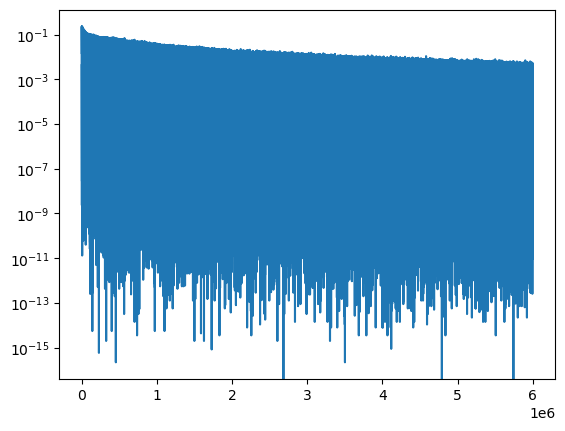

In [9]:
plt.plot(losses_plot)
plt.yscale("log")

# Lidar integration

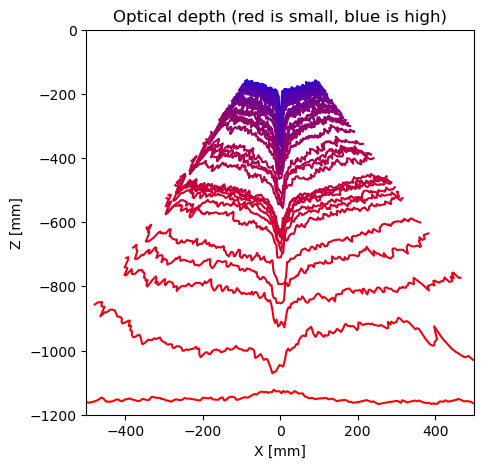

In [10]:
# First, plot the lidar data as a function of optical depth

dir = "pd_scans/"
dtheta = 0.25/180*np.pi # step size, radians
tank_height = 1.2192 * 1e3 # tank height in mm
theta0 = 29.2/180*np.pi # Initial angle of lidar scan, in radians

#########

scan_ls = []
tau_ls = []
avg_ls = []
all_files = [f for f in listdir(dir) if isfile(join(dir, f))]
files=[]

fig, ax = plt.subplots(figsize=(5,5))
for file in all_files:
    match = re.search(".*\.ubh",file)
    if match != None:
        files.append(file)
        scanxz,scanrtheta,scan_tau = get_scan(str(str(dir)+file),theta0,dtheta)
        scanxz[:,1] = -scanxz[:,1]
        scan_ls.append(scanrtheta)
        tau_ls.append(scan_tau)
        avg_ls.append(np.average(scanxz[:,1]))

        q=0.75
        ax.plot(scanxz[:,0],scanxz[:,1],color=[(q-scan_tau)/q,0,(scan_tau/q)])
        #ax.plot(scanrtheta[:,1],scanrtheta[:,0]/np.cos(scanrtheta[:,1]),color=[(q-scan_tau)/q,0,(scan_tau/q)])
        #print(file)
        #fig, ax = plt.subplots(figsize=(5,5))
        #ax.plot(scan[:,0],scan[:,1])
        #ax.set_title(str("tau: "+str(scan_tau)))
        #plt.show()
ax.set_xlim(-500,500)
ax.set_ylim(-1200,0)
ax.set_xlabel("X [mm]")
ax.set_ylabel("Z [mm]")
ax.set_title("Optical depth (red is small, blue is high)")
plt.show()
#plt.scatter(tau_ls,np.abs(avg_ls))


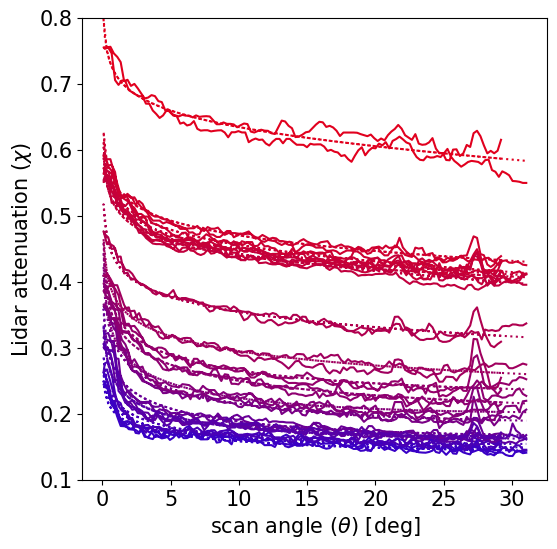

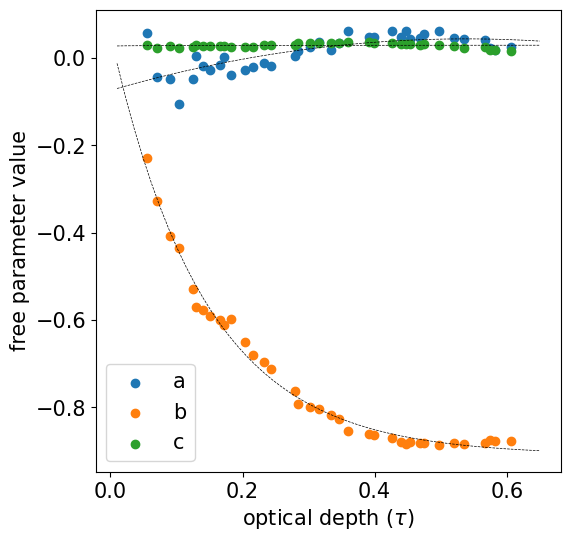

In [11]:
# Now, consider the angular dependance
# Identify which scan is the "baseline" (scan index "index")
index = 0
for i in range(len(tau_ls)):
    if tau_ls[i] <= tau_ls[index]:
        index = i

# Plot the attenuation as a function of angle and optical depth
# and fit a curve to the shape
def func(x, a, b, c):
    #return np.exp(-x+a)+b
    return a*x + b + x**(-c)
    
fact_ls = [] # stores what fraction of the distance the lidar could see
fit_ls = [] # saves fit coeffs.
fig, ax = plt.subplots(figsize=(6,6))
for i in range(len(scan_ls)):
    # Compute the attenuation fraction and save
    dat = scan_ls[i][:,0] / scan_ls[index][:,0]
    fact_ls.append(dat)

    # Fit the attenuation as a function of angle for each optical depth
    popt, pcov = curve_fit(func, np.abs(scan_ls[i][:,1]), dat)
    if i%2==0: # Dont plot every curve
        ax.plot(np.abs(scan_ls[i][:,1])*180/3.14,dat,color=[(q-tau_ls[i])/q,0,(tau_ls[i]/q)])
        if i!=index:
            plt.plot(np.abs(scan_ls[i][:,1])*180/3.14, func(np.abs(scan_ls[i][:,1]), *popt),linestyle="dotted",color=[(q-tau_ls[i])/q,0,(tau_ls[i]/q)])

    # Save fit coeffs.
    fit_ls.append(popt) # Ignore the fit for index "index"
    
ax.set_xlabel("scan angle ($θ$) [deg]",fontsize=15)
ax.set_ylabel("Lidar attenuation ($\chi$)",fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim(0.1,0.8)
#ax.set_title("Optical depth (red is small, blue is high)")
#ax.set_yscale("log")
plt.show()

#Plot the fit coeffs. as a function of tau
x = []
a = []
b = []
c = []
for i in range(len(fit_ls)):
    if i!=index:
        x.append(tau_ls[i])
        a.append(fit_ls[i][0])
        b.append(fit_ls[i][1])
        c.append(fit_ls[i][2])

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x,a,label="a")
ax.scatter(x,b,label="b")
ax.scatter(x,c,label="c")

# Fit the fits
def a_func(x, a1, a2, a3):
    return a1*x**2+a2*x+a3
a_params, pcov = curve_fit(a_func,x,a)
def b_func(x, b1, b2, b3):
    return b1*np.exp(-b2*x)+b3
b_params, pcov = curve_fit(b_func,x,b)
def c_func(x, c1, c2, c3):
    return c1*x**(-c2)+c3
c_params, pcov = curve_fit(c_func,x,c)

# plot the fits
x_axis = np.linspace(0.01,0.65,50)
a_fit = a_func(x_axis,*a_params)
b_fit = b_func(x_axis,*b_params)
c_fit = c_func(x_axis,*c_params)

ax.plot(x_axis,a_fit,color="black",linestyle="dashed",linewidth=0.5)
ax.plot(x_axis,b_fit,color="black",linestyle="dashed",linewidth=0.5)
ax.plot(x_axis,c_fit,color="black",linestyle="dashed",linewidth=0.5)

# Plot
#plt.title("Attenuation function fit parameters as a function of optical depth")
ax.legend(fontsize=15)
ax.set_xlabel("optical depth ($τ$)",fontsize=15)
ax.set_ylabel("free parameter value",fontsize=15)
ax.tick_params(axis='both', labelsize=15)
plt.show()

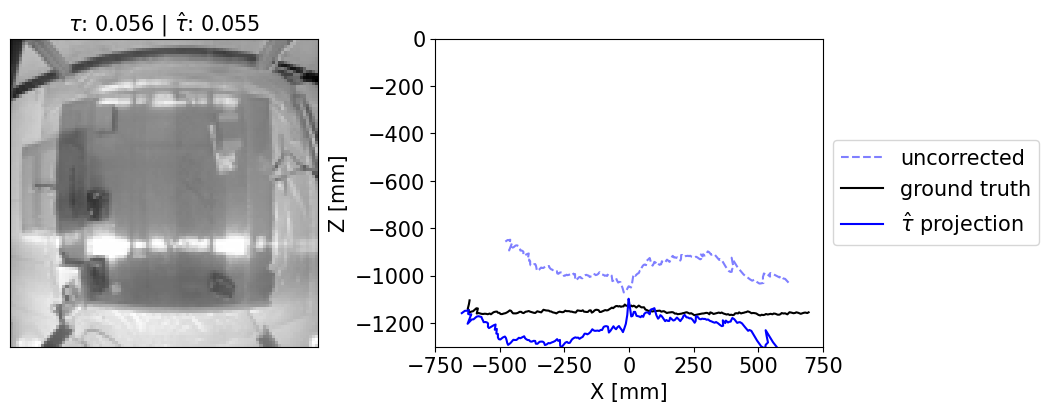

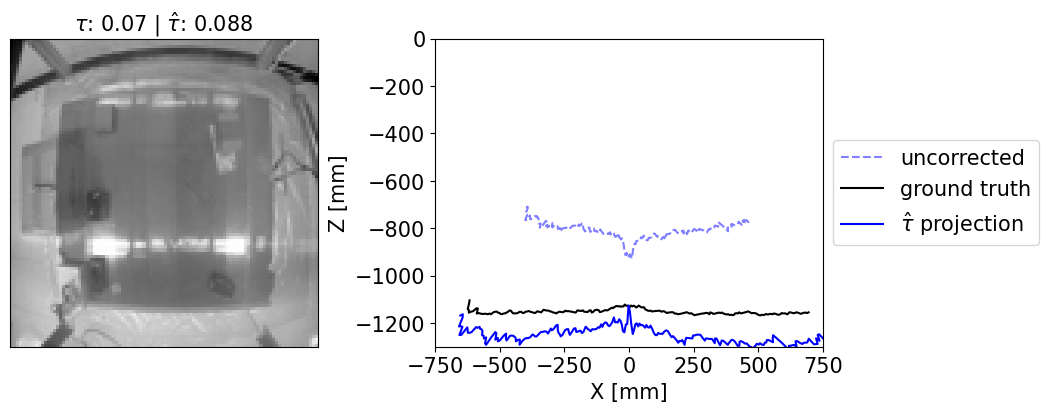

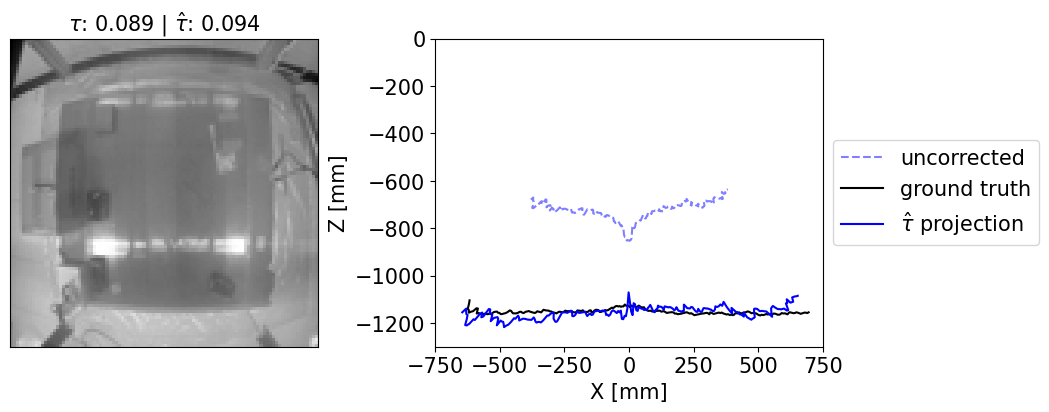

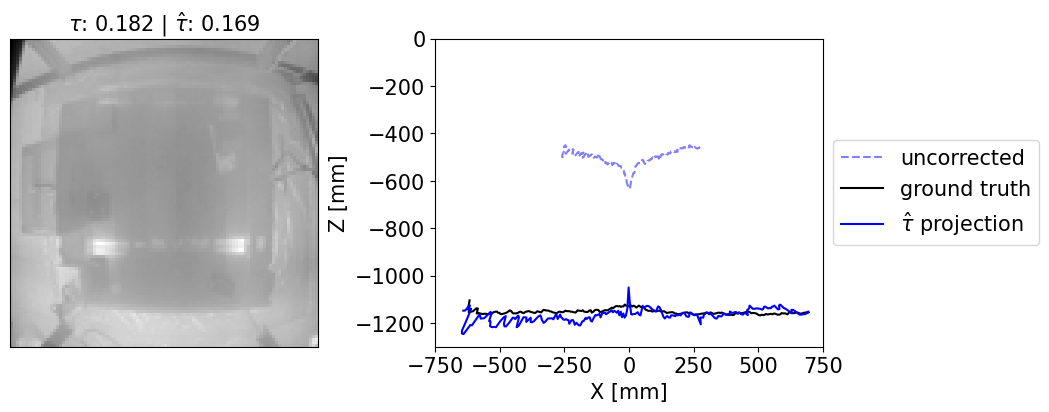

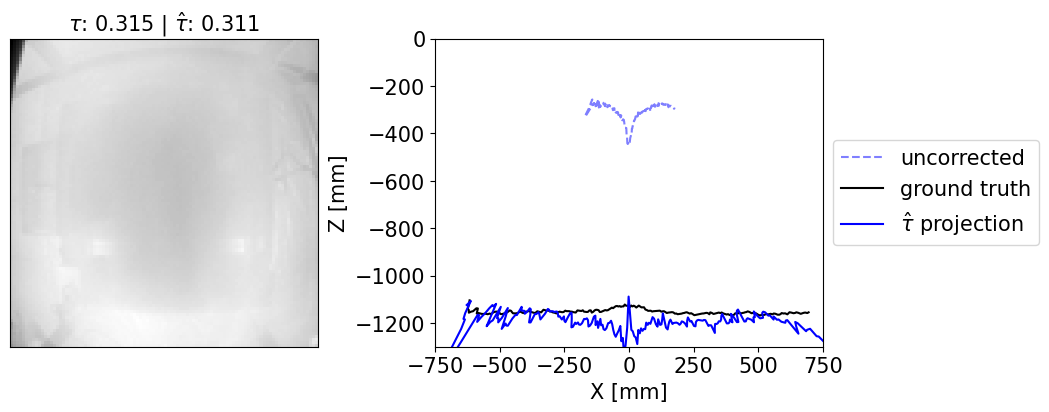

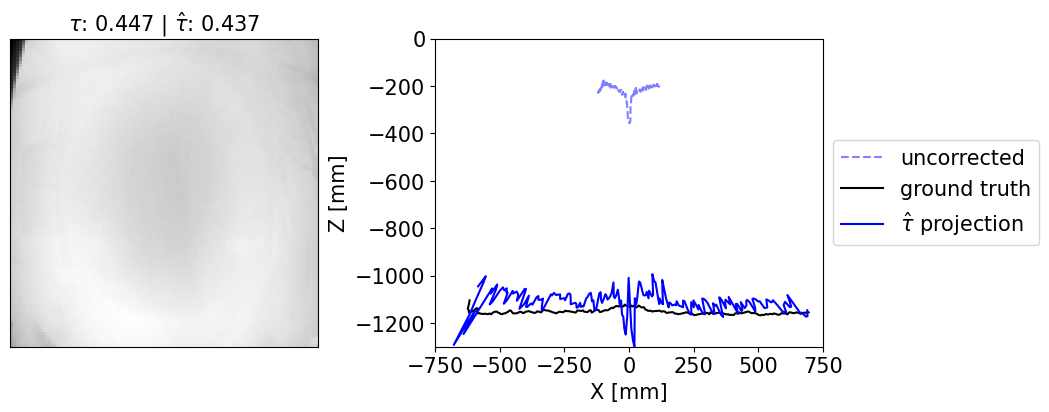

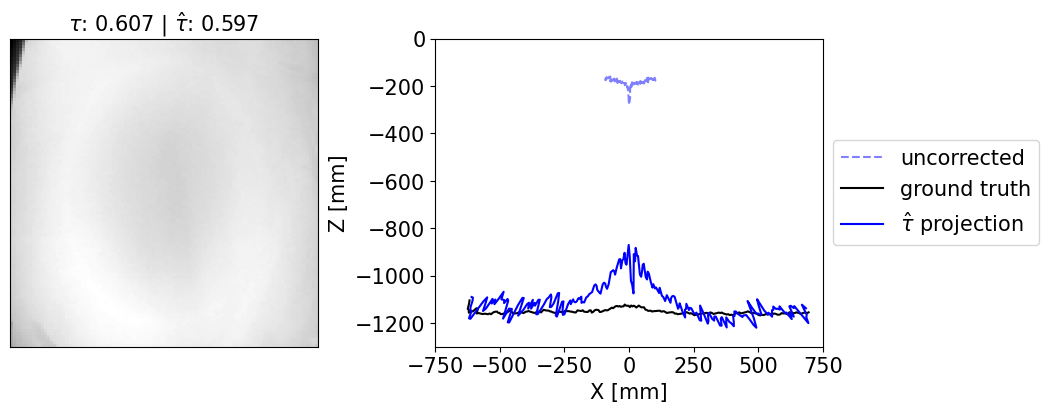

In [16]:
# Try out an example...
# For the v_max = 518 scans, we can test: (first one is reference....)
#image_files=["2_518_517.png","51_518_461.png","41_518_469.png","38_518_471.png","32_518_479.png"]
#scan_files=["518_517.ubh","518_461.ubh","518_469.ubh","518_471.ubh","518_479.ubh"]
image_files=["1_592_585.png","4_592_580.png","6_592_577.png","7_592_573.png","23_592_555.png","49_592_532.png","70_592_512.png","94_592_491.png"]
scan_files=["592_592.ubh","592_580.ubh","592_577.ubh","592_573.ubh","592_555.ubh","592_532.ubh","592_512.ubh","592_491.ubh"]

image_dir="pd_images/"
scan_dir="pd_scans/"

# Read in all the images and scans
im_ls = []
sc_ls = []
for i in range(len(image_files)):
    im_ls.append(get_image(str(image_dir+image_files[i]),size,size))
    sc_ls.append(get_scan(str(scan_dir+scan_files[i]),theta0,dtheta)) # recall that [0] is xz, [1] is rtheta, [2] is tau

# Convert to a tensor and evaluate
im_tensor = torch.tensor(np.reshape(im_ls, (len(im_ls),size**2))).float().to(device)
for i in range(1,len(image_files)):
    # Guess the optical depth using the CNN
    yhat = model(im_tensor[i]).detach().numpy().item()

    # Query the interpolating functions to get the fit parameters for the lidar attenuation
    a = a_func(yhat,*a_params)
    b = b_func(yhat,*b_params)
    c = c_func(yhat,*c_params)

    # Apply this to get the distance the lidar should have scanned
    r_corrected = sc_ls[i][1][:,0] / func(np.abs(sc_ls[i][1][:,1]),a,b,c)
    x_corrected = r_corrected * np.sin(sc_ls[i][1][:,1])
    z_corrected = - r_corrected * np.cos(sc_ls[i][1][:,1])
    
    # Plot reconstruction
    fig, ax = plt.subplots(ncols=2,figsize=(11,4))
    ax[0].imshow(im_ls[i],cmap="grey")
    ax[0].set_title("$τ$: "+str(round(sc_ls[i][2],3))+" | $\hat{τ}$: "+str(round(yhat,3)),fontsize=15)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].plot(sc_ls[i][0][:,0],-sc_ls[i][0][:,1],c="blue",linestyle="dashed",alpha = 0.5,label="uncorrected")
    ax[1].plot(sc_ls[0][0][:,0],-sc_ls[0  ][0][:,1],color="black",linestyle = "solid",alpha=1,label="ground truth")
    ax[1].plot(x_corrected, z_corrected,c="blue",label="$\hat{τ}$ projection")

    # Plot reconstruction using real tau
    a = a_func(sc_ls[i][2],*a_params)
    b = b_func(sc_ls[i][2],*b_params)
    c = c_func(sc_ls[i][2],*c_params)
    r_corrected = sc_ls[i][1][:,0] / func(np.abs(sc_ls[i][1][:,1]),a,b,c)
    x_corrected = r_corrected * np.sin(sc_ls[i][1][:,1])
    z_corrected = - r_corrected * np.cos(sc_ls[i][1][:,1])
    #ax[1].plot(x_corrected, z_corrected,c="blue",label="$τ$ projection",linestyle="dotted")

    ax[1].set_xlim(-750,750)
    ax[1].set_ylim(-1300,0)
    ax[1].set_xlabel("X [mm]",fontsize=15)
    ax[1].set_ylabel("Z [mm]",fontsize=15)
    ax[1].tick_params(axis='both', labelsize=15)
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)

# Utilities

In [7]:
# Relabel the image files using the recorded list of pd voltages:
# Input is directory of jpgs, which are renamed in order according to pd_ls and saved back to the dir as .pngs
# naming convention: x_yyy_zzz.png where x is a file count (can be ignored), yyy is the max photodiode voltage for that dataset, and zzz is the photodiode voltage for that image
dir = "raw_photos/"
panel = 1
all_files = [f for f in listdir(dir) if isfile(join(dir, f))]
files=[]
for file in all_files:
    match = re.search(".*\.jpg",file)
    if match != None:
        files.append(file)
files.sort()

count=55
for i in range(len(files)):
    img = iio.imread(str(dir+files[i]))
    iio.imwrite(str(dir+str(count).zfill(4)+"_"+str(panel)+".png"), img)
    count+=1

In [29]:
# Relabel the lidar scans
dir = "raw_scans/"
panel = 1
all_files = [f for f in listdir(dir) if isfile(join(dir, f))]
files=[]
for file in all_files:
    match = re.search(".*\.ubh",file)
    if match != None:
        files.append(file)
files.sort()

count=1
for i in range(len(files)):
    os.rename(str(dir+files[i]),str((dir+str(count).zfill(4)+"_"+str(panel)+'.ubh')))
    count+=1

In [2]:
test="1"

test.zfill(4)

'0001'